In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import shap

In [2]:
# Load the dataset
file_path = 'Raw Data/output.csv'
data = pd.read_csv(file_path)

In [3]:
print("Unique values in 'Sex' column before encoding:", data['Sex'].unique())

Unique values in 'Sex' column before encoding: ['M' 'F' 'F ' 'M ']


In [4]:
# Convert the target variable 'Anaemic' to binary format if not already done
data['Anaemic'] = data['Anaemic'].map({'Yes': 1, 'No': 0})

# Strip leading and trailing spaces from 'Sex' column values
data['Sex'] = data['Sex'].str.strip()

#Drop the Number column
data = data.drop(columns=['Number'])

# One-hot encode the 'Sex' column
data = pd.get_dummies(data, columns=['Sex'], drop_first=False)

In [5]:
# Display columns after dropping the incorrect column
print("Columns after dropping the incorrect column:", data.columns)

Columns after dropping the incorrect column: Index(['%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb', 'Anaemic', 'Sex_F',
       'Sex_M'],
      dtype='object')


In [6]:
# Define features and target variable
X = data.drop(columns=['Anaemic'])
y = data['Anaemic']

print(X.columns, y.head)

Index(['%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb', 'Sex_F', 'Sex_M'], dtype='object') <bound method NDFrame.head of 0      1
1      0
2      0
3      0
4      0
      ..
99     1
100    1
101    0
102    0
103    0
Name: Anaemic, Length: 104, dtype: int64>


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scale numerical features
scaler = StandardScaler()

numerical_features = ['%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Display the first few rows of the training data
X_train.head(), y_train.head()

(    %Red Pixel  %Green pixel  %Blue pixel        Hb  Sex_F  Sex_M
 55    0.232238     -0.396178    -0.016480  0.364549  False   True
 22   -0.849241      0.601300     0.706724 -0.014724   True  False
 76    1.486522      0.031227    -2.063656 -0.941836   True  False
 44   -0.520533      0.031895     0.689954  0.828104  False   True
 72    2.720115     -1.430409    -2.641536 -0.267573   True  False,
 55    0
 22    0
 76    1
 44    0
 72    0
 Name: Anaemic, dtype: int64)

In [9]:
# Initialize k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)

In [10]:
# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
# Predict on the test set
y_pred = knn.predict(X_test)

In [12]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"Accuracy: {accuracy:.2f}")


Confusion Matrix:
[[16  0]
 [ 0  5]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 1.00


The initial k-NN model seems to be performing reasonably well with an accuracy of 81%. However, given the objective is to minimize false negatives, we should focus on improving the recall for the positive class which only had a score of 60%.

Next Steps

1. Tune k-NN Hyperparameters: Adjust the number of neighbors (k) to see if performance improves.
2. Evaluate with Cross-Validation: Use cross-validation to get a more reliable estimate of model performance.
3. Try other models like logistic regression or neural networks


In [13]:
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 11)}

In [14]:
# Initialize GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')

In [15]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 11)}, scoring='recall')

In [16]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation recall: {best_score:.2f}")

Best parameters: {'n_neighbors': 3}
Best cross-validation recall: 0.75


In [17]:
# Train the k-NN model with the best parameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
# Predict on the test set
y_pred_best = knn_best.predict(X_test)


In [19]:
# Evaluate the model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)
accuracy_best = accuracy_score(y_test, y_pred_best)

print("\nConfusion Matrix (Best k-NN):")
print(conf_matrix_best)
print("\nClassification Report (Best k-NN):")
print(class_report_best)
print(f"Accuracy: {accuracy_best:.2f}")


Confusion Matrix (Best k-NN):
[[16  0]
 [ 0  5]]

Classification Report (Best k-NN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 1.00


Observations

The recall is 0.60, meaning that 60% of actual anemic patients are correctly identified.

The precision is 0.50, indicating that when the model predicts anemia, it is correct 50% of the time.

The overall accuracy is 0.76, which is decent but not the best metric for imbalanced datasets.

With only 5 anemic patients in the test set, small changes can significantly impact recall.
k-NN might not be the best model for this dataset due to its reliance on distances, which can be less effective with high dimensional or imbalanced data.


In [20]:
# Initialize logistic regression model with class weight adjustment
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

In [21]:
# Fit the model
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [22]:
# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)


In [23]:
# Evaluate the model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print("\nConfusion Matrix (Logistic Regression):")
print(conf_matrix_log_reg)
print("\nClassification Report (Logistic Regression):")
print(class_report_log_reg)
print(f"Accuracy: {accuracy_log_reg:.2f}")


Confusion Matrix (Logistic Regression):
[[16  0]
 [ 0  5]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 1.00


Observations 

There is no such thing as a perfect model this is over fitting, most likely due to the small dataset size. 

Next Step

Implement SMOTE and Random Oversampling to increase the size of the dataset overall and also handle the class imbalance a bit better

In [24]:
# Apply SMOTE to the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [25]:
# Apply RandomOverSampler to the majority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_res, y_res)

In [26]:
# Check the distribution of the new resampled dataset
print("Resampled dataset distribution:")
print(y_resampled.value_counts())


Resampled dataset distribution:
Anaemic
1    78
0    78
Name: count, dtype: int64


In [27]:
# Split the resampled data into training and testing sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [28]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']
X_train_res[numerical_features] = scaler.fit_transform(X_train_res[numerical_features])
X_test_res[numerical_features] = scaler.transform(X_test_res[numerical_features])

In [29]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [30]:
# Initialize logistic regression model with class weight adjustment
log_reg_smote = LogisticRegression(class_weight='balanced', random_state=42)

In [31]:
# Fit the model
log_reg_smote.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', random_state=42)

In [32]:
# Predict on the test set
y_pred_smote = log_reg_smote.predict(X_test_res)

In [33]:
# Evaluate the model
conf_matrix_smote = confusion_matrix(y_test_res, y_pred_smote)
class_report_smote = classification_report(y_test_res, y_pred_smote)
accuracy_smote = accuracy_score(y_test_res, y_pred_smote)

print("\nConfusion Matrix (Logistic Regression with SMOTE and Random Oversampling):")
print(conf_matrix_smote)
print("\nClassification Report (Logistic Regression with SMOTE and Random Oversampling):")
print(class_report_smote)
print(f"Accuracy: {accuracy_smote:.2f}")


Confusion Matrix (Logistic Regression with SMOTE and Random Oversampling):
[[12  2]
 [ 2 16]]

Classification Report (Logistic Regression with SMOTE and Random Oversampling):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.89      0.89      0.89        18

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32

Accuracy: 0.88


Observations 

Both precision and recall for the minority class (anemic patients) are high, indicating the model is effectively identifying anemic patients without sacrificing too much performance on the non-anemic patients.

Given the improved results with logistic regression using SMOTE and random oversampling,we should continue with other models and techniques to see if further improvements can be made.


In [34]:
# Initialize neural network model
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

In [35]:
# Fit the model on the resampled training data
mlp.fit(X_train_res, y_train_res)

/Users/jin/Desktop/Anaemia Prediction/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

In [36]:
# Predict on the test set
y_pred_mlp = mlp.predict(X_test_res)

In [37]:
# Evaluate the model
conf_matrix_mlp = confusion_matrix(y_test_res, y_pred_mlp)
class_report_mlp = classification_report(y_test_res, y_pred_mlp)
accuracy_mlp = accuracy_score(y_test_res, y_pred_mlp)

print("\nConfusion Matrix (Neural Network):")
print(conf_matrix_mlp)
print("\nClassification Report (Neural Network):")
print(class_report_mlp)
print(f"Accuracy: {accuracy_mlp:.2f}")


Confusion Matrix (Neural Network):
[[12  2]
 [ 2 16]]

Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.89      0.89      0.89        18

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32

Accuracy: 0.88


In [38]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000]
}

In [39]:
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

/Users/jin/Desktop/Anaemia Prediction/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jin/Desktop/Anaemia Prediction/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jin/Desktop/Anaemia Prediction/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jin/Desktop/Anaemia Prediction/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [500, 1000]},
             scoring='accuracy')

In [40]:
print("Best parameters found by grid search:", grid_search.best_params_)

Best parameters found by grid search: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 500}


In [41]:
# Retrain the model with the best parameters
mlp_best = grid_search.best_estimator_
mlp_best.fit(X_train_res, y_train_res)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500,
              random_state=42)

In [42]:
# Predict on the test set
y_pred_mlp_best = mlp_best.predict(X_test_res)

In [43]:
# Evaluate the model
conf_matrix_mlp_best = confusion_matrix(y_test_res, y_pred_mlp_best)
class_report_mlp_best = classification_report(y_test_res, y_pred_mlp_best)
accuracy_mlp_best = accuracy_score(y_test_res, y_pred_mlp_best)

print("\nConfusion Matrix (Tuned Neural Network):")
print(conf_matrix_mlp_best)
print("\nClassification Report (Tuned Neural Network):")
print(class_report_mlp_best)
print(f"Accuracy: {accuracy_mlp_best:.2f}")


Confusion Matrix (Tuned Neural Network):
[[12  2]
 [ 2 16]]

Classification Report (Tuned Neural Network):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.89      0.89      0.89        18

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32

Accuracy: 0.88


Observations
The results from the neural network being similar to those of the logistic regression model indicate that the balanced dataset provided by SMOTE and random oversampling has resulted in consistent performance across different models. This is a positive outcome, showing that the resampling technique effectively addressed the class imbalance.

Next Steps

1. While the initial models have shown good performance, we can explore hyperparameter tuning for both logistic regression and the neural network to see if there is room for further improvement.

2. Prepare the best-performing model for deployment 

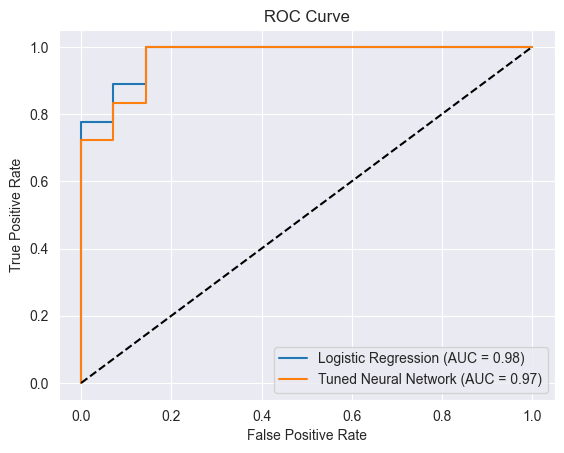

<Figure size 640x480 with 0 Axes>

In [44]:
# Logistic Regression
y_pred_prob_log_reg = log_reg_smote.predict_proba(X_test_res)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test_res, y_pred_prob_log_reg)
roc_auc_log_reg = roc_auc_score(y_test_res, y_pred_prob_log_reg)

# Tuned Neural Network
y_pred_prob_mlp_best = mlp_best.predict_proba(X_test_res)[:, 1]
fpr_mlp_best, tpr_mlp_best, _ = roc_curve(y_test_res, y_pred_prob_mlp_best)
roc_auc_mlp_best = roc_auc_score(y_test_res, y_pred_prob_mlp_best)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_mlp_best, tpr_mlp_best, label=f'Tuned Neural Network (AUC = {roc_auc_mlp_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save the plot as an image file
plt.savefig('roc_curve.png')

In [45]:
# Logistic Regression Coefficients
coefficients = pd.DataFrame(log_reg_smote.coef_, columns=X.columns)
print(coefficients)

   %Red Pixel  %Green pixel  %Blue pixel        Hb   Sex_F     Sex_M
0   -0.242807      1.379777     -0.75987 -2.738702  0.9496  0.123493


In [46]:
# Save the logistic regression model
joblib.dump(log_reg_smote, 'logistic_regression_model.pkl')

# Save the tuned neural network model
joblib.dump(mlp_best, 'neural_network_model.pkl')

['neural_network_model.pkl']